# full unique keys      : 490
# processed unique keys : 482
… pre-computing distances & similarities

=== 결과 미리보기 (상위 15행) ===
   metric   thr  kept  reduction
0    edit  0.00   472   0.036735
1    edit  1.00   474   0.032653
2    edit  2.00   479   0.022449
3    edit  3.00   481   0.018367
4    edit  4.00   482   0.016327
5    edit  5.00   482   0.016327
6     sim  0.40   482   0.016327
7     sim  0.45   482   0.016327
8     sim  0.50   482   0.016327
9     sim  0.55   482   0.016327
10    sim  0.60   482   0.016327
11    sim  0.65   482   0.016327
12    sim  0.70   482   0.016327
13    sim  0.75   481   0.018367
14    sim  0.80   481   0.018367


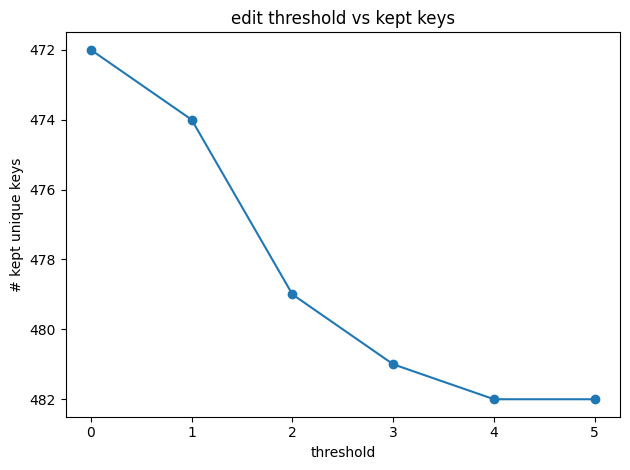

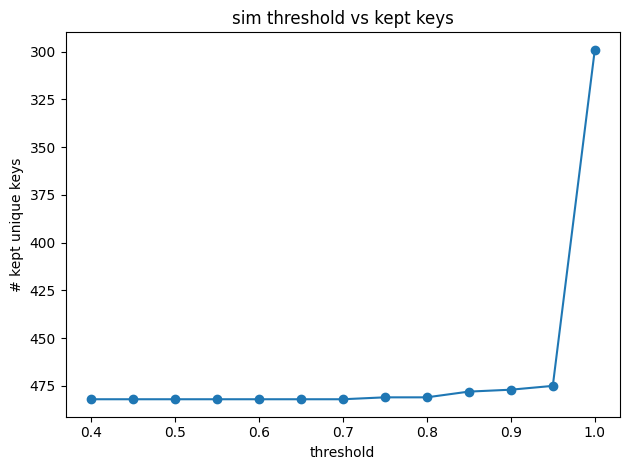

In [12]:
import json
from collections import Counter
from pathlib import Path
import pandas as pd

# ---------- 경로 ----------
FULL_PATH = Path("annotation_results/full_annotation_try8.json")
PROC_PATH = Path("annotation_merge/processed_annotations_t8.json")

# -*- coding: utf-8 -*-
"""
state_threshold_scan.py
"""


# ───────────────────────────────────────────────────────
# 2. 라이브러리 준비
#   · edit distance: python-Levenshtein (가장 빠름) → 없으면 difflib fallback
#   · embedding: sentence-transformers
try:
    from Levenshtein import distance as edit_dist
except ImportError:                     # 간단한 fallback
    import difflib
    edit_dist = lambda a, b: int(round((1 - difflib.SequenceMatcher(None, a, b).ratio()) * max(len(a), len(b))))

from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer("all-MiniLM-L6-v2")   # 384-dim, fast & small

# ───────────────────────────────────────────────────────
# 3. 데이터 로드 & 평탄화
def flatten_state(nested):
    return {f"{d}_{s}": v for d, slots in nested.items() for s, v in slots.items()}

def load_states(path, processed=False):
    with path.open() as f:
        data = json.load(f)
    states = []
    if processed:    # our processed file 구조: {"annotations":[...]}
        for ann in data["annotations"]:
            st = ann.get("state_after") or {}
            states.append(st)           # 이미 평탄화돼 있다고 가정
    else:
        for dlg in data:
            for turn in dlg.get("turns", []):
                states.append(flatten_state(turn.get("state") or {}))
    return states

full_states = load_states(FULL_PATH)
proc_states = load_states(PROC_PATH, processed=True)

full_keys = sorted({k for s in full_states for k in s})
proc_keys = sorted({k for s in proc_states for k in s})

print(f"# full unique keys      : {len(full_keys)}")
print(f"# processed unique keys : {len(proc_keys)}")

# ───────────────────────────────────────────────────────
# 4. 전처리: 모든 processed key ↔ full key 간 거리·유사도 미리 계산
print("… pre-computing distances & similarities")
# embeddings 한꺼번에
emb_full = model.encode(full_keys, normalize_embeddings=True, batch_size=128)
emb_proc = model.encode(proc_keys, normalize_embeddings=True, batch_size=128)

# cosine similarity matrix (num_proc × num_full)
cos_sim_mat = util.cos_sim(emb_proc, emb_full).cpu().numpy()

# edit distance 미리 계산 (처리량이 많으면 chunking 권장)
edit_mat = np.empty((len(proc_keys), len(full_keys)), dtype=np.int16)
for i, pk in enumerate(proc_keys):
    for j, fk in enumerate(full_keys):
        edit_mat[i, j] = edit_dist(pk, fk)

# 각 processed key당 best-match 기록
best_edit = edit_mat.min(axis=1)              # shape (num_proc,)
best_sim  = cos_sim_mat.max(axis=1)           # shape (num_proc,)

# ───────────────────────────────────────────────────────
# 5. threshold sweep
edit_thresh  = list(range(0, 6))              # 0,1,2,3,4,5
sim_thresh   = np.round(np.arange(0.4, 1.01, 0.05), 2)  # 0.40~1.00

rows = []
N_full_keys = len(full_keys)

for t in edit_thresh:
    keep = best_edit <= t
    kept = keep.sum()
    red  = 1 - kept / N_full_keys    # 감축률: full-key 대비
    rows.append({"metric":"edit", "thr":t, "kept":kept, "reduction":red})

for s in sim_thresh:
    keep = best_sim >= s
    kept = keep.sum()
    red  = 1 - kept / N_full_keys
    rows.append({"metric":"sim", "thr":s, "kept":kept, "reduction":red})

df = pd.DataFrame(rows).sort_values(["metric","thr"])
print("\n=== 결과 미리보기 (상위 15행) ===")
print(df.head(15))

# 필요하면 csv, 그래프 저장
df.to_csv("state_threshold_scan.csv", index=False)

# 예: matplotlib 그래프 간단 예시
import matplotlib.pyplot as plt
for m in ["edit","sim"]:
    sub = df[df.metric==m]
    plt.figure()
    plt.title(f"{m} threshold vs kept keys")
    plt.plot(sub["thr"], sub["kept"], marker="o")
    plt.xlabel("threshold")
    plt.ylabel("# kept unique keys")
    plt.gca().invert_yaxis()   # 키 수 ↓ 방향으로 보기 편하면
    plt.tight_layout()
    plt.show()


In [28]:
import json, itertools, unicodedata, re, Levenshtein as lev
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm

FILE = Path("annotation_results/full_annotation_try8.json")

# -------- 1. raw key 수집 --------
def flatten(state):
    return {f"{d}_{s}" for d,slots in state.items() for s in slots}

raw_keys = set()
for dlg in json.load(FILE.open()):
    for t in dlg.get("turns", []):
        raw_keys |= flatten(t.get("state") or {})

print("raw unique keys :", len(raw_keys))  # 예: 512개

# -------- 2. 간단 정규화 --------
def norm(k:str) -> str:
    k = unicodedata.normalize("NFKD", k).lower()
    k = re.sub(r"[^a-z0-9_]+","_", k)
    k = re.sub(r"_+","_", k).strip("_")
    return k

normed = {k: norm(k) for k in raw_keys}

# -------- 3. threshold별 머지 --------
def merged_count(thr:int)->int:
    parent = {k:k for k in raw_keys}
    def find(x):
        while parent[x]!=x:
            parent[x]=parent[parent[x]]
            x=parent[x]
        return x
    def union(a,b):
        ra,rb=find(a),find(b)
        if ra!=rb: parent[rb]=ra

    for a,b in itertools.combinations(raw_keys,2):
        if lev.distance(normed[a], normed[b])<=thr:
            union(a,b)

    reps = {find(k) for k in raw_keys}
    return len(reps)

for t in range(0,15):
    cnt = merged_count(t)
    print(f"edit≤{t}: unique keys → {cnt}")


raw unique keys : 490
edit≤0: unique keys → 490
edit≤1: unique keys → 474
edit≤2: unique keys → 441
edit≤3: unique keys → 324
edit≤4: unique keys → 224
edit≤5: unique keys → 115
edit≤6: unique keys → 70
edit≤7: unique keys → 42
edit≤8: unique keys → 26
edit≤9: unique keys → 13
edit≤10: unique keys → 7
edit≤11: unique keys → 5
edit≤12: unique keys → 4
edit≤13: unique keys → 2
edit≤14: unique keys → 2


In [29]:
import json, itertools, unicodedata, re
from pathlib import Path
from collections import defaultdict
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# FILE = Path("/mnt/data/full_annotation_try8.json")

# ------ 1. raw key 수집 -------------------------------------------------
def flatten(state):
    return {f"{d}_{s}" for d,slots in state.items() for s in slots}

raw_keys=set()
for dlg in json.load(FILE.open()):
    for t in dlg.get("turns", []):
        raw_keys |= flatten(t.get("state") or {})
print("raw unique keys:", len(raw_keys))           # 예: 512

# ------ 2. 간단 정규화(동일 철자만 맞춰 주기) --------------------------
def norm(k):
    k = unicodedata.normalize("NFKD", k).lower()
    k = re.sub(r"[^a-z0-9_]+","_",k)
    k = re.sub(r"_+","_",k).strip("_")
    return k
normed = [norm(k) for k in raw_keys]

# ------ 3. 임베딩 계산 ---------------------------------------------------
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(normed, normalize_embeddings=True, batch_size=128)

# ------ 4. 코사인 기반 군집 함수 ---------------------------------------
def merged_cnt(sim_thr:float) -> int:
    parent = list(range(len(raw_keys)))
    def find(x):
        while parent[x]!=x:
            parent[x]=parent[parent[x]]
            x=parent[x]
        return x
    def union(a,b):
        ra,rb=find(a),find(b)
        if ra!=rb: parent[rb]=ra

    for i,j in itertools.combinations(range(len(raw_keys)),2):
        if util.cos_sim(emb[i], emb[j]) >= sim_thr:
            union(i,j)

    reps = {find(i) for i in range(len(raw_keys))}
    return len(reps)

# ------ 5. 스캔: 0.50 ~ 0.95 -------------------------------------------
for thr in np.round(np.arange(0.50, 0.96, 0.05),2)[::-1]:
    cnt = merged_cnt(thr)
    print(f"sim≥{thr:.2f}: unique keys → {cnt}")


raw unique keys: 490
sim≥0.95: unique keys → 465
sim≥0.90: unique keys → 386
sim≥0.85: unique keys → 234
sim≥0.80: unique keys → 105
sim≥0.75: unique keys → 46
sim≥0.70: unique keys → 19
sim≥0.65: unique keys → 8
sim≥0.60: unique keys → 5
sim≥0.55: unique keys → 3
sim≥0.50: unique keys → 2


raw unique keys: 490
   edit_thr  sim_thr  unique_keys
0         0     0.60            5
1         0     0.65            8
2         0     0.70           19
3         0     0.75           46
4         0     0.80          105
CSV와 heatmap 저장 완료.


/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3464759285.py:92: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3464759285.py:92: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3464759285.py:92: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3464759285.py:92: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3464759285.py:93: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  plt.savefig("joint_threshold_heatmap.png")
/var/folders/w9/24t5cz0n3wg3

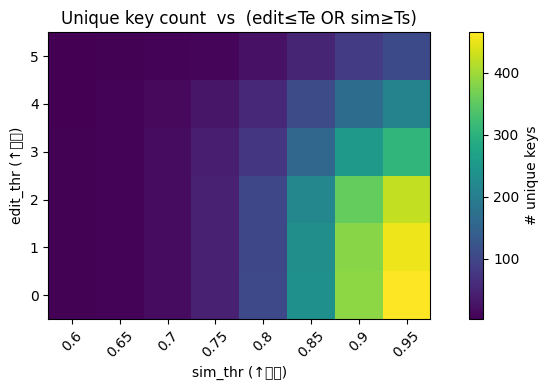

In [35]:
# joint_threshold_scan.py
import json, unicodedata, re, itertools, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import Levenshtein as lev
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt

RAW = Path("annotation_results/full_annotation_try8.json")

# ────────────────────────────── 1. 원본 key 수집 ──────────────────────────────
def flatten(state):
    return {f"{d}_{s}" for d,slots in state.items() for s in slots}

raw_keys=set()

for dlg in json.load(RAW.open()):
    for t in dlg.get("turns", []):
        raw_keys |= flatten(t.get("state") or {})

print("raw unique keys:", len(raw_keys))        # 예: 512

# ────────────────────────────── 2. 정규화 ────────────────────────────────────
def norm(k:str)->str:
    k = unicodedata.normalize("NFKD", k).lower()
    k = re.sub(r"[^a-z0-9_]+","_",k)
    return re.sub(r"_+","_",k).strip("_")

normed = [norm(k) for k in raw_keys]

# ────────────────────────────── 3. 임베딩 준비 ───────────────────────────────
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(normed, normalize_embeddings=True, batch_size=128)

# ────────────────────────────── 4. 거리·유사도 행렬 ──────────────────────────
N = len(raw_keys)
edit_mat = np.zeros((N,N), dtype=np.uint8)
cos_mat  = util.cos_sim(emb, emb).cpu().numpy()  # 대칭행렬

for i,j in itertools.combinations(range(N),2):
    edit_mat[i,j] = edit_mat[j,i] = lev.distance(normed[i], normed[j])

# ────────────────────────────── 5. 군집 함수 ────────────────────────────────
def merged_cnt(edit_thr:int, sim_thr:float)->int:
    parent = list(range(N))
    def find(x):
        while parent[x]!=x:
            parent[x]=parent[parent[x]]
            x=parent[x]
        return x
    def union(a,b):
        ra,rb=find(a),find(b);  parent[rb]=ra

    # 조건:  edit≤Te **OR** sim≥Ts
    cond_edit = edit_mat <= edit_thr
    cond_sim  = cos_mat  >= sim_thr
    adj = np.logical_or(cond_edit, cond_sim)

    for i,j in zip(*np.triu_indices_from(adj, k=1)):
        if adj[i,j]: union(i,j)

    reps = {find(i) for i in range(N)}
    return len(reps)

# ────────────────────────────── 6. 스캔 & 결과 --------------------------------
edit_thrs = range(0,6)                       # 0~5
sim_thrs  = np.round(np.arange(0.60,0.96,0.05),2)  # 0.60~0.95

rows=[]
for e in edit_thrs:
    for s in sim_thrs:
        rows.append({
            "edit_thr":e,
            "sim_thr":float(s),
            "unique_keys":merged_cnt(e,s)
        })
df=pd.DataFrame(rows)
df.to_csv("joint_threshold_stats.csv",index=False)
print(df.head())

# ────────────────────────────── 7. 피벗·히트맵 --------------------------------
pivot = df.pivot(index="edit_thr", columns="sim_thr", values="unique_keys")
plt.figure(figsize=(8,4))
plt.title("Unique key count  vs  (edit≤Te OR sim≥Ts)")
plt.xlabel("sim_thr (↑엄격)")
plt.ylabel("edit_thr (↑느슨)")
plt.imshow(pivot, cmap="viridis", origin="lower")
plt.colorbar(label="# unique keys")
plt.xticks(ticks=range(len(sim_thrs)), labels=sim_thrs, rotation=45)
plt.yticks(ticks=range(len(edit_thrs)), labels=edit_thrs)
plt.tight_layout()
plt.savefig("joint_threshold_heatmap.png")
print("CSV와 heatmap 저장 완료.")


raw unique keys: 490
   edit_thr  sim_thr  unique_keys
0         0    0.500            2
1         0    0.525            3
2         0    0.550            3
3         0    0.575            3
4         0    0.600            5


/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/2785772634.py:135: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/2785772634.py:135: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/2785772634.py:135: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/2785772634.py:135: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/2785772634.py:136: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  plt.savefig("joint_threshold_3d_visualization.png", dpi=300, bbox_

3D 시각화 파일들 저장 완료:
- joint_threshold_3d_visualization.png
- gradient_descent_style_visualization.png
- joint_threshold_stats.csv


/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


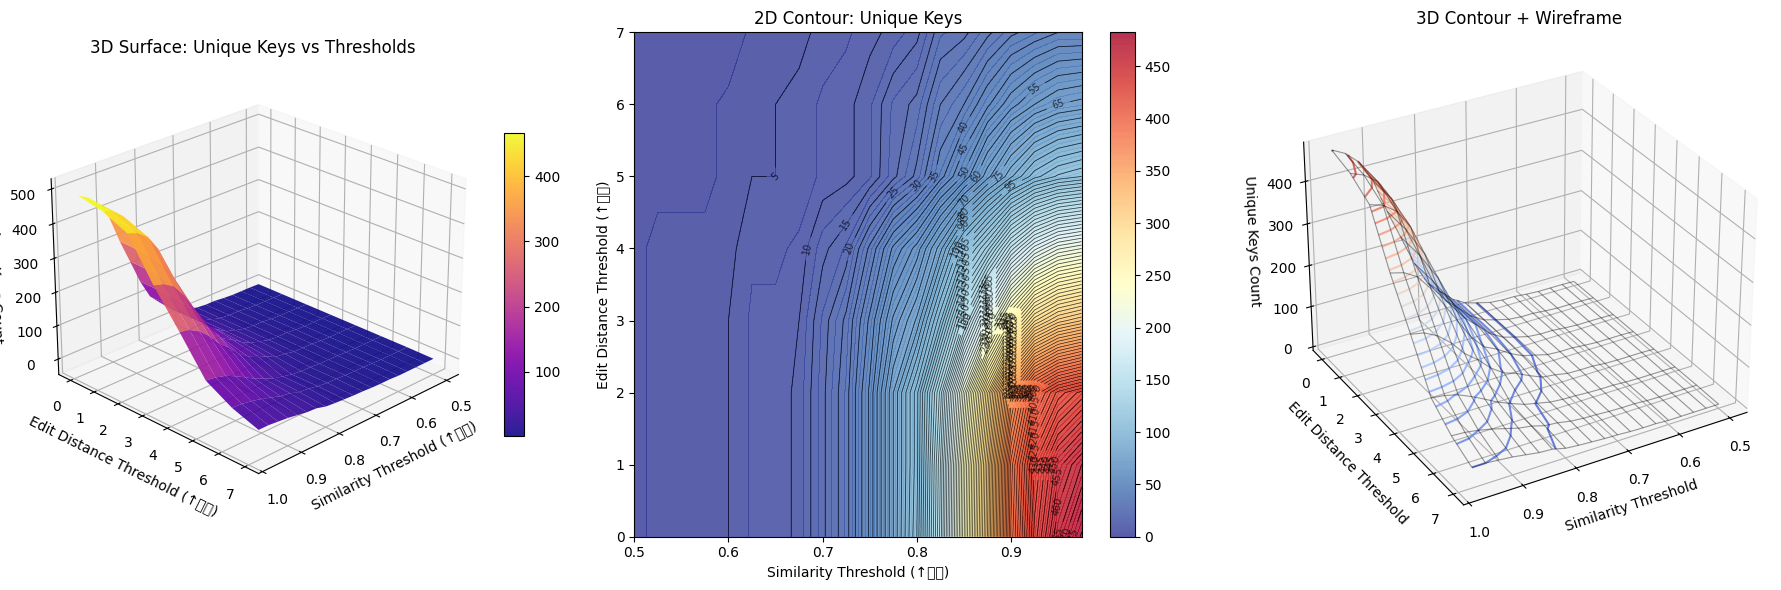

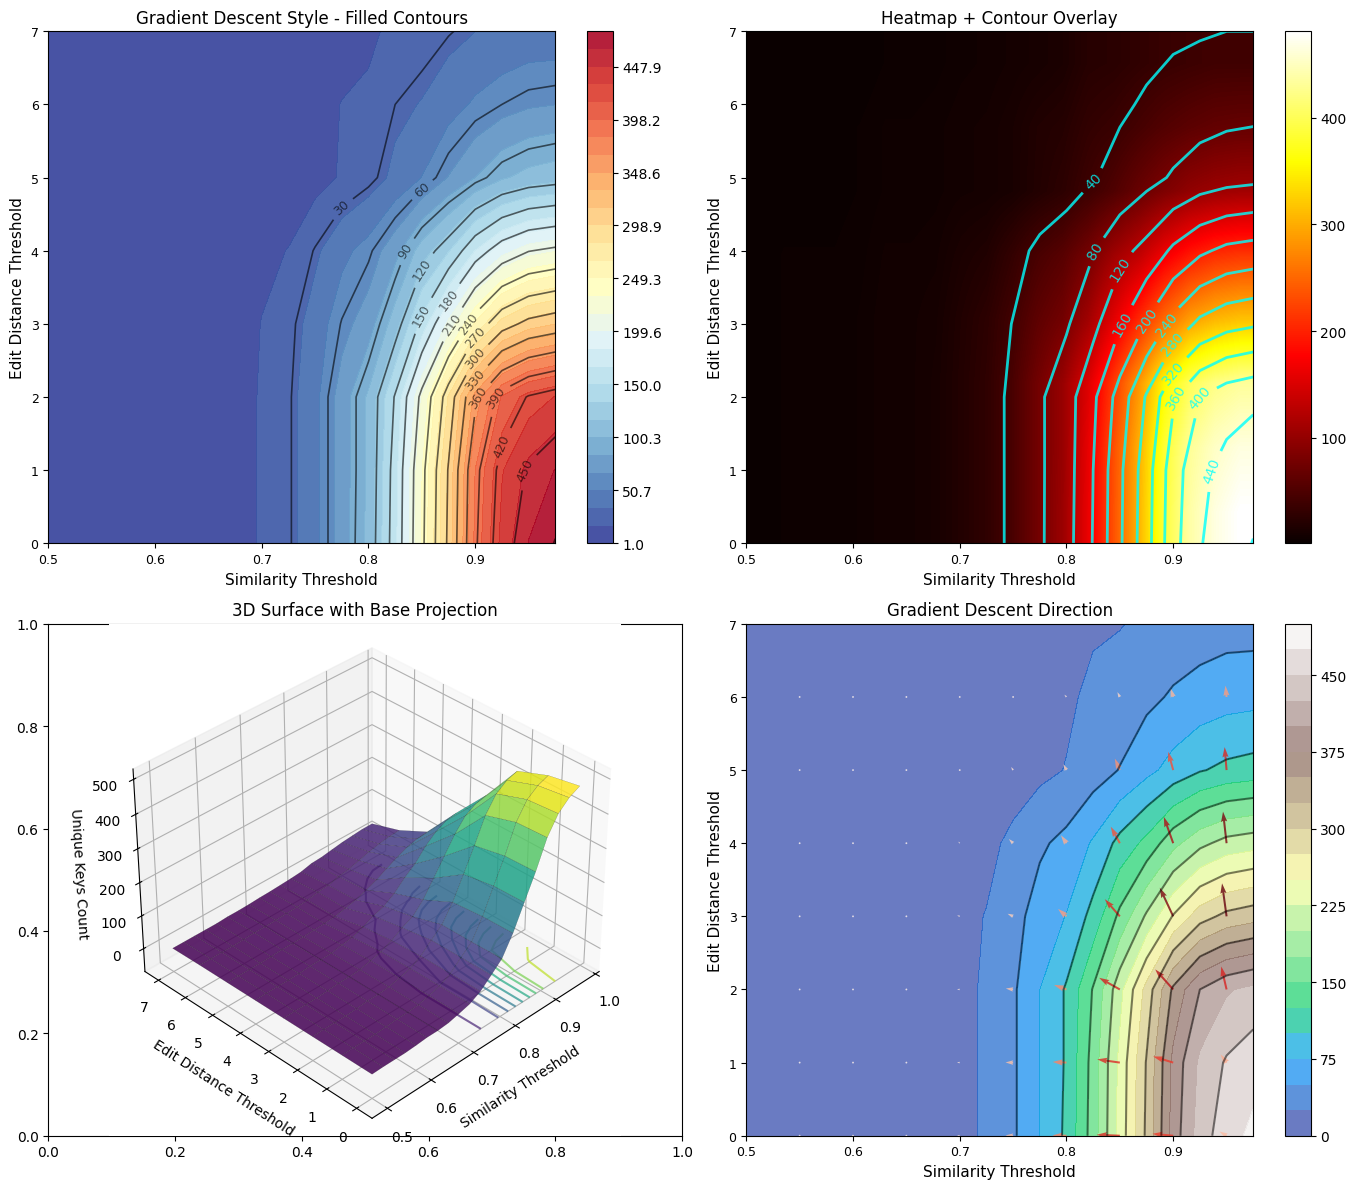

In [37]:
# joint_threshold_scan_3d.py
import json, unicodedata, re, itertools, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import Levenshtein as lev
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter

RAW = Path("annotation_results/full_annotation_try8.json")

# ────────────────────────────── 1. 원본 key 수집 ──────────────────────────────
def flatten(state):
    return {f"{d}_{s}" for d,slots in state.items() for s in slots}

raw_keys=set()

for dlg in json.load(RAW.open()):
    for t in dlg.get("turns", []):
        raw_keys |= flatten(t.get("state") or {})

print("raw unique keys:", len(raw_keys))        # 예: 512

# ────────────────────────────── 2. 정규화 ────────────────────────────────────
def norm(k:str)->str:
    k = unicodedata.normalize("NFKD", k).lower()
    k = re.sub(r"[^a-z0-9_]+","_",k)
    return re.sub(r"_+","_",k).strip("_")

normed = [norm(k) for k in raw_keys]

# ────────────────────────────── 3. 임베딩 준비 ───────────────────────────────
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(normed, normalize_embeddings=True, batch_size=128)

# ────────────────────────────── 4. 거리·유사도 행렬 ──────────────────────────
N = len(raw_keys)
edit_mat = np.zeros((N,N), dtype=np.uint8)
cos_mat  = util.cos_sim(emb, emb).cpu().numpy()  # 대칭행렬

for i,j in itertools.combinations(range(N),2):
    edit_mat[i,j] = edit_mat[j,i] = lev.distance(normed[i], normed[j])

# ────────────────────────────── 5. 군집 함수 ────────────────────────────────
def merged_cnt(edit_thr:int, sim_thr:float)->int:
    parent = list(range(N))
    def find(x):
        while parent[x]!=x:
            parent[x]=parent[parent[x]]
            x=parent[x]
        return x
    def union(a,b):
        ra,rb=find(a),find(b);  parent[rb]=ra

    # 조건:  edit≤Te **OR** sim≥Ts
    cond_edit = edit_mat <= edit_thr
    cond_sim  = cos_mat  >= sim_thr
    adj = np.logical_or(cond_edit, cond_sim)

    for i,j in zip(*np.triu_indices_from(adj, k=1)):
        if adj[i,j]: union(i,j)

    reps = {find(i) for i in range(N)}
    return len(reps)

# ────────────────────────────── 6. 스캔 & 결과 --------------------------------
# 더 넓은 범위와 세밀한 그리드로 차이를 더 명확하게
edit_thrs = range(0,8)                       # 0~7 (확장)
sim_thrs  = np.round(np.arange(0.50,1.00,0.025),3)  # 0.50~0.975, 더 세밀한 스텝

rows=[]
for e in edit_thrs:
    for s in sim_thrs:
        rows.append({
            "edit_thr":e,
            "sim_thr":float(s),
            "unique_keys":merged_cnt(e,s)
        })
df=pd.DataFrame(rows)
df.to_csv("joint_threshold_stats.csv",index=False)
print(df.head())

# ────────────────────────────── 7. 3D 시각화 --------------------------------
pivot = df.pivot(index="edit_thr", columns="sim_thr", values="unique_keys")

# 메쉬그리드 생성
X, Y = np.meshgrid(sim_thrs, edit_thrs)
Z = pivot.values

# 첫 번째 그림: 3D Surface Plot
fig = plt.figure(figsize=(18, 6))

# 서브플롯 1: 3D Surface (더 나은 뷰 앵글과 컬러맵)
ax1 = fig.add_subplot(131, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='plasma', alpha=0.9, 
                       rstride=1, cstride=1, linewidth=0, antialiased=True)
ax1.view_init(elev=25, azim=45)  # 최적의 뷰 앵글
ax1.set_xlabel('Similarity Threshold (↑엄격)', fontsize=10)
ax1.set_ylabel('Edit Distance Threshold (↑느슨)', fontsize=10)
ax1.set_zlabel('Unique Keys Count', fontsize=10)
ax1.set_title('3D Surface: Unique Keys vs Thresholds', fontsize=12)
# Z축 범위 조정으로 차이 강조
z_min, z_max = Z.min(), Z.max()
ax1.set_zlim(z_min - (z_max-z_min)*0.1, z_max + (z_max-z_min)*0.1)
fig.colorbar(surf, ax=ax1, shrink=0.6, aspect=15)

# 서브플롯 2: 2D Contour Plot (더 많은 등고선과 대비 강한 컬러)
ax2 = fig.add_subplot(132)
levels_count = max(20, int((Z.max() - Z.min()) / 5))  # 동적 레벨 수
contours = ax2.contour(X, Y, Z, levels=levels_count, colors='black', alpha=0.7, linewidths=0.6)
contourf = ax2.contourf(X, Y, Z, levels=levels_count*2, cmap='RdYlBu_r', alpha=0.8)
ax2.clabel(contours, inline=True, fontsize=7, fmt='%d')
ax2.set_xlabel('Similarity Threshold (↑엄격)', fontsize=10)
ax2.set_ylabel('Edit Distance Threshold (↑느슨)', fontsize=10)
ax2.set_title('2D Contour: Unique Keys', fontsize=12)
# 축 틱 조정
ax2.set_xticks(sim_thrs[::4])  # 4개마다 표시
ax2.set_yticks(edit_thrs[::1])  # 모든 값 표시
fig.colorbar(contourf, ax=ax2)

# 서브플롯 3: 3D Contour + Wireframe (더 명확한 구조)
ax3 = fig.add_subplot(133, projection='3d')
# 3D contour (더 많은 레벨)
ax3.contour3D(X, Y, Z, levels=25, cmap='coolwarm', alpha=0.8)
# Wireframe for structure (더 굵은 선)
ax3.plot_wireframe(X, Y, Z, alpha=0.4, color='black', linewidth=0.8)
ax3.view_init(elev=30, azim=60)  # 다른 각도에서 보기
ax3.set_xlabel('Similarity Threshold', fontsize=10)
ax3.set_ylabel('Edit Distance Threshold', fontsize=10)
ax3.set_zlabel('Unique Keys Count', fontsize=10)
ax3.set_title('3D Contour + Wireframe', fontsize=12)

plt.tight_layout()
plt.savefig("joint_threshold_3d_visualization.png", dpi=300, bbox_inches='tight')

# ────────────────────────────── 8. Gradient-style 시각화 ─────────────────────
# Gradient descent에서 자주 보는 스타일의 그림 (개선된 버전)
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 12))

# 1. Filled contour with gradient colors (더 세밀한 레벨)
levels = np.linspace(Z.min(), Z.max(), 30)
im1 = ax1.contourf(X, Y, Z, levels=levels, cmap='RdYlBu_r', alpha=0.9)
contour1 = ax1.contour(X, Y, Z, levels=15, colors='black', alpha=0.6, linewidths=1.2)
ax1.clabel(contour1, inline=True, fontsize=9, fmt='%d')
ax1.set_title('Gradient Descent Style - Filled Contours', fontsize=12)
ax1.set_xlabel('Similarity Threshold', fontsize=11)
ax1.set_ylabel('Edit Distance Threshold', fontsize=11)
# 축 틱 개선
ax1.set_xticks(sim_thrs[::4])
ax1.set_yticks(edit_thrs[::1])
ax1.tick_params(axis='both', which='major', labelsize=9)
plt.colorbar(im1, ax=ax1)

# 2. Heat map with contour overlay (대비 강화)
im2 = ax2.imshow(Z, extent=[X.min(), X.max(), Y.min(), Y.max()], 
                 origin='lower', cmap='hot', aspect='auto', interpolation='bilinear')
contour2 = ax2.contour(X, Y, Z, levels=12, colors='cyan', alpha=0.8, linewidths=2)
ax2.clabel(contour2, inline=True, fontsize=10, colors='cyan', fmt='%d')
ax2.set_title('Heatmap + Contour Overlay', fontsize=12)
ax2.set_xlabel('Similarity Threshold', fontsize=11)
ax2.set_ylabel('Edit Distance Threshold', fontsize=11)
ax2.set_xticks(sim_thrs[::4])
ax2.set_yticks(edit_thrs[::1])
ax2.tick_params(axis='both', which='major', labelsize=9)
plt.colorbar(im2, ax=ax2)

# 3. 3D surface with color gradient (더 나은 각도와 투영)
ax3 = fig2.add_subplot(223, projection='3d')
surf = ax3.plot_surface(X, Y, Z, cmap='viridis', alpha=0.85, 
                       rstride=1, cstride=1, linewidth=0.1, antialiased=True,
                       edgecolor='black')
# Add contour projections on the bottom (더 명확하게)
offset = Z.min() - (Z.max() - Z.min()) * 0.15
ax3.contour(X, Y, Z, zdir='z', offset=offset, cmap='viridis', alpha=0.7, levels=10)
ax3.view_init(elev=35, azim=225)  # 최적 각도
ax3.set_xlabel('Similarity Threshold', fontsize=10)
ax3.set_ylabel('Edit Distance Threshold', fontsize=10) 
ax3.set_zlabel('Unique Keys Count', fontsize=10)
ax3.set_title('3D Surface with Base Projection', fontsize=12)
# Z축 범위 조정
ax3.set_zlim(offset, Z.max() + (Z.max() - Z.min()) * 0.1)

# 4. Gradient arrows (더 명확한 방향 표시)
base_contour = ax4.contourf(X, Y, Z, levels=20, cmap='terrain', alpha=0.7)
# Calculate gradients (스무딩 적용)
Z_smooth = gaussian_filter(Z, sigma=0.5)
grad_y, grad_x = np.gradient(Z_smooth)
# Subsample for cleaner arrows (적응적 샘플링)
step_x = max(1, len(sim_thrs) // 8)
step_y = max(1, len(edit_thrs) // 6)
# 화살표 크기를 gradient 크기에 비례하게
grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
max_mag = np.max(grad_magnitude)
ax4.quiver(X[::step_y, ::step_x], Y[::step_y, ::step_x], 
          -grad_x[::step_y, ::step_x]/max_mag, -grad_y[::step_y, ::step_x]/max_mag, 
          grad_magnitude[::step_y, ::step_x], 
          alpha=0.8, scale=15, cmap='Reds', width=0.004)
ax4.contour(X, Y, Z, levels=10, colors='black', alpha=0.5, linewidths=1.5)
ax4.set_title('Gradient Descent Direction', fontsize=12)
ax4.set_xlabel('Similarity Threshold', fontsize=11)
ax4.set_ylabel('Edit Distance Threshold', fontsize=11)
ax4.set_xticks(sim_thrs[::4])
ax4.set_yticks(edit_thrs[::1])
ax4.tick_params(axis='both', which='major', labelsize=9)
plt.colorbar(base_contour, ax=ax4)

plt.tight_layout()
plt.savefig("gradient_descent_style_visualization.png", dpi=300, bbox_inches='tight')

print("3D 시각화 파일들 저장 완료:")
print("- joint_threshold_3d_visualization.png")
print("- gradient_descent_style_visualization.png")
print("- joint_threshold_stats.csv")

Total unique keys: 490
🎯 최적 Threshold 찾기 분석 시작...
🔍 1차원 스캔 분석...


/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3141870899.py:267: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3141870899.py:267: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3141870899.py:267: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3141870899.py:267: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w9/24t5cz0n3wg31ckppwmk6bbm0000gn/T/ipykernel_60973/3141870899.py:268: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  plt.savefig("threshold_optimization_analysis.png", dpi=300, bbox_i


🎯 추천 Threshold 조합:
----------------------------------------
1. Conservative | edit≤1, sim≥0.90 | 382 keys (-22.0%)
2. Elbow-based  | edit≤0, sim≥0.60 |   5 keys (-99.0%)
3. Moderate     | edit≤3, sim≥0.80 |  76 keys (-84.5%)
4. Aggressive   | edit≤4, sim≥0.75 |  31 keys (-93.7%)

💡 상세 분석:

==================== Conservative Strategy ====================

📊 Threshold (edit≤1 OR sim≥0.9) 분석:
   총 클러스터 수: 382
   Merge된 그룹 수: 60
   단독 key 수: 322
   Key 감소: 490 → 382 (-108, 22.0%)

🔗 Merge된 그룹들 (상위 5개):

   그룹 1 (크기: 9):
      1. taxi_time
      2. taxi_depart_time
      3. taxi_leave_time
      4. taxi_arrival_time
      5. taxi_departure_time
      6. taxi_arrive_time
      7. taxi_pick_up_time
      8. taxi_pickup_time
      9. taxi_travel_time
         (그룹 내 최소 edit거리: 1, 최대 유사도: 0.964)

   그룹 2 (크기: 8):
      1. train_time_arrival
      2. train_arrive_time
      3. train_arrival
      4. train_arrival_destination
      5. train_arrival_time_actual
      6. train_arrival_location
     

/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50628 (\N{HANGUL SYLLABLE EOM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45712 (\N{HANGUL SYLLABLE NEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/hyegang/Desktop/졸업논문/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49832 (\N{HANGUL SYLLABLE SEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


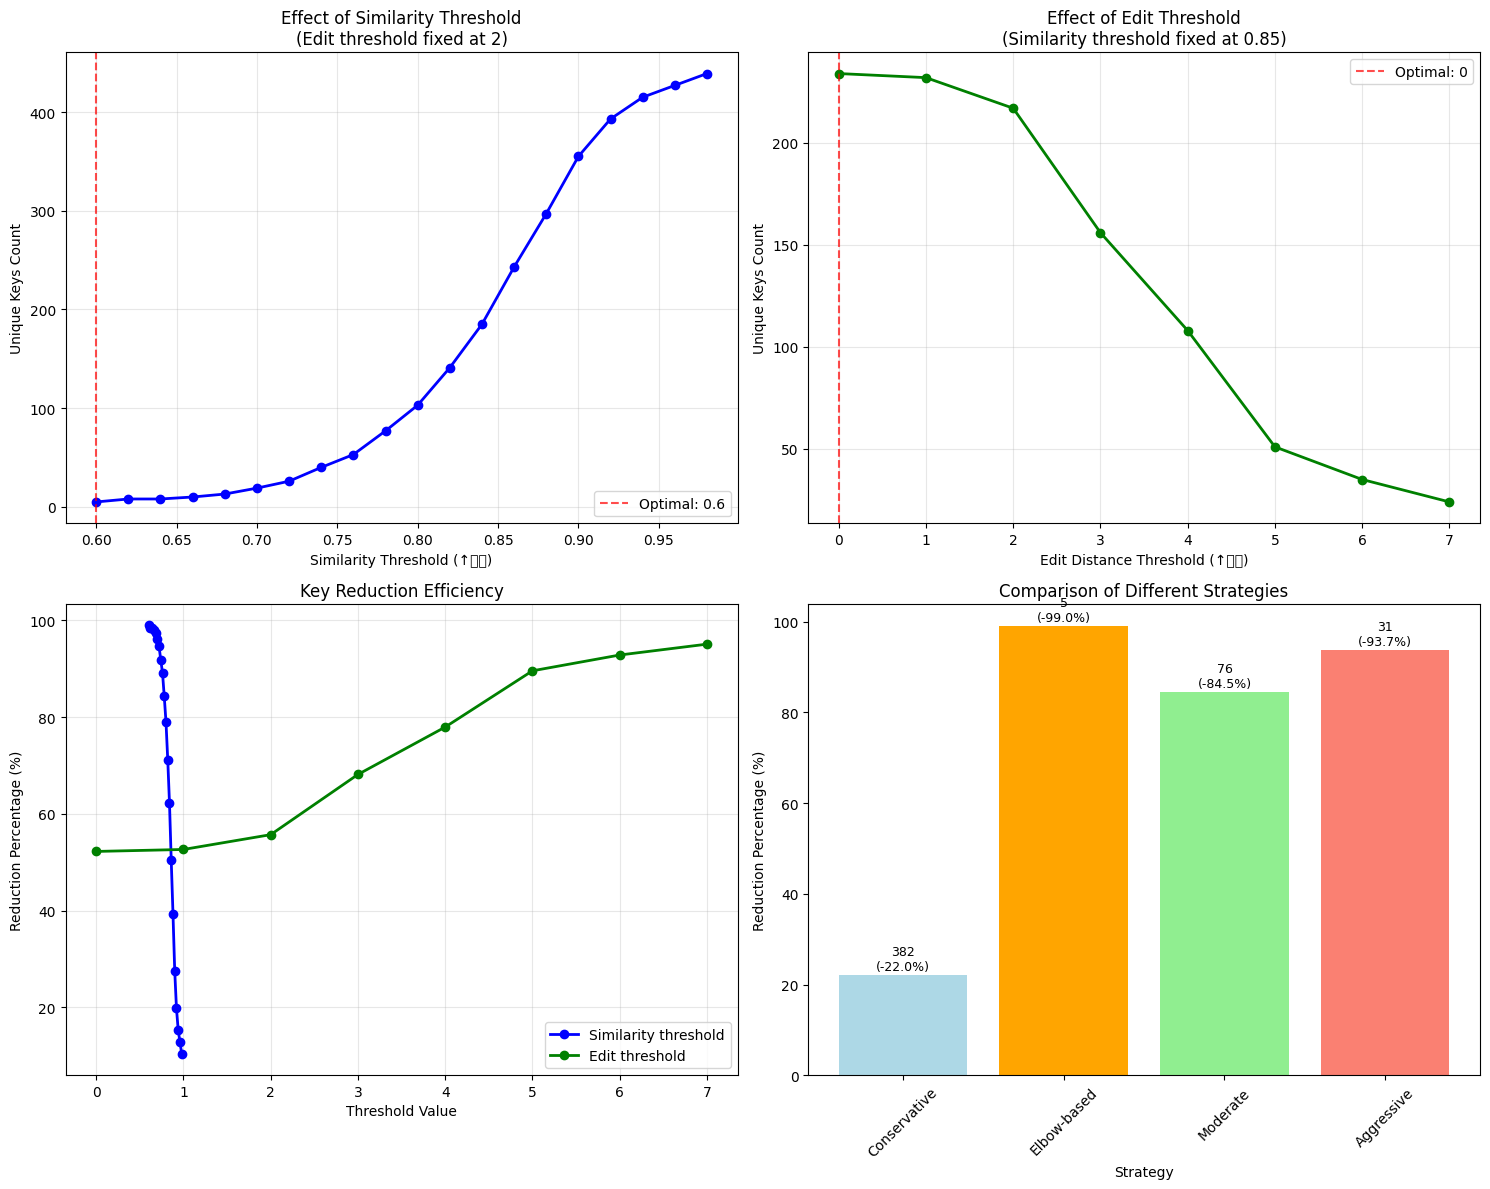

In [40]:
# threshold_optimization.py
import json, unicodedata, re, itertools, numpy as np, pandas as pd
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import Levenshtein as lev
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from kneed import KneeLocator

RAW = Path("annotation_results/full_annotation_try8.json")

# ────────────────────────────── 1. 원본 key 수집 & 정규화 ──────────────────────
def flatten(state):
    return {f"{d}_{s}" for d,slots in state.items() for s in slots}

def norm(k:str)->str:
    k = unicodedata.normalize("NFKD", k).lower()
    k = re.sub(r"[^a-z0-9_]+","_",k)
    return re.sub(r"_+","_",k).strip("_")

raw_keys=set()
for dlg in json.load(RAW.open()):
    for t in dlg.get("turns", []):
        raw_keys |= flatten(t.get("state") or {})

raw_keys = list(raw_keys)
normed = [norm(k) for k in raw_keys]
print(f"Total unique keys: {len(raw_keys)}")

# ────────────────────────────── 2. 임베딩 & 거리 행렬 ─────────────────────────
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(normed, normalize_embeddings=True, batch_size=128)

N = len(raw_keys)
edit_mat = np.zeros((N,N), dtype=np.uint8)
cos_mat  = util.cos_sim(emb, emb).cpu().numpy()

for i,j in itertools.combinations(range(N),2):
    edit_mat[i,j] = edit_mat[j,i] = lev.distance(normed[i], normed[j])

# ────────────────────────────── 3. 군집 함수 (개선된 버전) ─────────────────────
def get_merged_clusters(edit_thr:int, sim_thr:float):
    """Union-Find로 클러스터링하고 실제 merge된 그룹들 반환"""
    parent = list(range(N))
    def find(x):
        while parent[x]!=x:
            parent[x]=parent[parent[x]]
            x=parent[x]
        return x
    def union(a,b):
        ra,rb=find(a),find(b)
        if ra != rb: parent[rb]=ra

    # 조건: edit≤Te OR sim≥Ts
    cond_edit = edit_mat <= edit_thr
    cond_sim  = cos_mat  >= sim_thr
    adj = np.logical_or(cond_edit, cond_sim)

    for i,j in zip(*np.triu_indices_from(adj, k=1)):
        if adj[i,j]: union(i,j)

    # 클러스터 그룹화
    clusters = defaultdict(list)
    for i in range(N):
        clusters[find(i)].append(i)
    
    return dict(clusters)

def merged_cnt(edit_thr:int, sim_thr:float)->int:
    """클러스터 개수만 반환"""
    return len(get_merged_clusters(edit_thr, sim_thr))

# ────────────────────────────── 4. Elbow Method 적용 ──────────────────────────
def find_optimal_thresholds():
    """여러 방법으로 최적 threshold 찾기"""
    
    # 1차원 스캔으로 각 threshold의 효과 분석
    edit_range = range(0, 8)
    sim_range = np.round(np.arange(0.60, 1.00, 0.02), 3)
    
    print("🔍 1차원 스캔 분석...")
    
    # Edit threshold 고정하고 similarity threshold 변화
    fixed_edit = 2  # 중간 값
    sim_results = []
    for s in sim_range:
        count = merged_cnt(fixed_edit, s)
        reduction_pct = (len(raw_keys) - count) / len(raw_keys) * 100
        sim_results.append({
            'sim_thr': s,
            'unique_keys': count,
            'reduction_pct': reduction_pct
        })
    
    # Similarity threshold 고정하고 edit threshold 변화  
    fixed_sim = 0.85  # 중간 값
    edit_results = []
    for e in edit_range:
        count = merged_cnt(e, fixed_sim)
        reduction_pct = (len(raw_keys) - count) / len(raw_keys) * 100
        edit_results.append({
            'edit_thr': e,
            'unique_keys': count,
            'reduction_pct': reduction_pct
        })
    
    # Elbow detection
    def detect_elbow(data, x_col, y_col):
        x_vals = [d[x_col] for d in data]
        y_vals = [d[y_col] for d in data]
        
        try:
            # KneeLocator를 사용한 자동 elbow detection
            kl = KneeLocator(x_vals, y_vals, curve="convex", direction="decreasing")
            return kl.elbow
        except:
            # 수동 방법: 2차 미분 최대값
            if len(y_vals) < 3:
                return x_vals[len(x_vals)//2]
            
            # 2차 미분 계산
            first_diff = np.diff(y_vals)
            second_diff = np.diff(first_diff)
            
            if len(second_diff) > 0:
                elbow_idx = np.argmax(np.abs(second_diff)) + 1
                return x_vals[min(elbow_idx, len(x_vals)-1)]
            return x_vals[len(x_vals)//2]
    
    optimal_sim = detect_elbow(sim_results, 'sim_thr', 'unique_keys')
    optimal_edit = detect_elbow(edit_results, 'edit_thr', 'unique_keys')
    
    return {
        'sim_results': sim_results,
        'edit_results': edit_results,
        'optimal_sim': optimal_sim,
        'optimal_edit': optimal_edit,
        'fixed_edit': fixed_edit,
        'fixed_sim': fixed_sim
    }

# ────────────────────────────── 5. 실제 merge 예시 분석 ──────────────────────
def analyze_merge_examples(edit_thr, sim_thr, max_examples=10):
    """실제로 merge되는 key들의 예시 분석"""
    clusters = get_merged_clusters(edit_thr, sim_thr)
    
    # 크기가 2 이상인 클러스터만 (실제로 merge된 것들)
    merged_clusters = {k: v for k, v in clusters.items() if len(v) > 1}
    
    print(f"\n📊 Threshold (edit≤{edit_thr} OR sim≥{sim_thr}) 분석:")
    print(f"   총 클러스터 수: {len(clusters)}")
    print(f"   Merge된 그룹 수: {len(merged_clusters)}")
    print(f"   단독 key 수: {len(clusters) - len(merged_clusters)}")
    
    reduction = len(raw_keys) - len(clusters)
    print(f"   Key 감소: {len(raw_keys)} → {len(clusters)} (-{reduction}, {reduction/len(raw_keys)*100:.1f}%)")
    
    # 예시 출력
    print(f"\n🔗 Merge된 그룹들 (상위 {max_examples}개):")
    sorted_clusters = sorted(merged_clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
    for i, (cluster_id, indices) in enumerate(sorted_clusters[:max_examples]):
        keys_in_cluster = [raw_keys[idx] for idx in indices]
        normed_in_cluster = [normed[idx] for idx in indices]
        
        print(f"\n   그룹 {i+1} (크기: {len(indices)}):")
        for j, (orig, norm) in enumerate(zip(keys_in_cluster, normed_in_cluster)):
            print(f"      {j+1}. {orig}")
            if norm != orig.lower():
                print(f"         (정규화: {norm})")
        
        # 그룹 내 유사도 정보
        if len(indices) > 1:
            min_edit = float('inf')
            max_sim = 0.0
            for x, y in itertools.combinations(indices, 2):
                min_edit = min(min_edit, edit_mat[x,y])
                max_sim = max(max_sim, cos_mat[x,y])
            print(f"         (그룹 내 최소 edit거리: {min_edit}, 최대 유사도: {max_sim:.3f})")
    
    return len(clusters), reduction

# ────────────────────────────── 6. 종합 분석 & 시각화 ──────────────────────────
def comprehensive_analysis():
    """종합적인 threshold 최적화 분석"""
    
    print("🎯 최적 Threshold 찾기 분석 시작...")
    print("="*60)
    
    # Elbow method 적용
    results = find_optimal_thresholds()
    
    # 시각화
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Similarity threshold 효과 (edit=2 고정)
    sim_data = results['sim_results']
    x_sim = [d['sim_thr'] for d in sim_data]
    y_sim = [d['unique_keys'] for d in sim_data]
    
    ax1.plot(x_sim, y_sim, 'bo-', linewidth=2, markersize=6)
    ax1.axvline(results['optimal_sim'], color='red', linestyle='--', alpha=0.7, 
                label=f'Optimal: {results["optimal_sim"]}')
    ax1.set_xlabel('Similarity Threshold (↑엄격)')
    ax1.set_ylabel('Unique Keys Count')
    ax1.set_title(f'Effect of Similarity Threshold\n(Edit threshold fixed at {results["fixed_edit"]})')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # 2. Edit threshold 효과 (sim=0.85 고정)
    edit_data = results['edit_results']
    x_edit = [d['edit_thr'] for d in edit_data]
    y_edit = [d['unique_keys'] for d in edit_data]
    
    ax2.plot(x_edit, y_edit, 'go-', linewidth=2, markersize=6)
    ax2.axvline(results['optimal_edit'], color='red', linestyle='--', alpha=0.7,
                label=f'Optimal: {results["optimal_edit"]}')
    ax2.set_xlabel('Edit Distance Threshold (↑느슨)')
    ax2.set_ylabel('Unique Keys Count')
    ax2.set_title(f'Effect of Edit Threshold\n(Similarity threshold fixed at {results["fixed_sim"]})')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # 3. Reduction percentage
    reduction_sim = [(len(raw_keys) - d['unique_keys'])/len(raw_keys)*100 for d in sim_data]
    reduction_edit = [(len(raw_keys) - d['unique_keys'])/len(raw_keys)*100 for d in edit_data]
    
    ax3.plot(x_sim, reduction_sim, 'bo-', linewidth=2, label='Similarity threshold')
    ax3.plot(x_edit, reduction_edit, 'go-', linewidth=2, label='Edit threshold')
    ax3.set_xlabel('Threshold Value')
    ax3.set_ylabel('Reduction Percentage (%)')
    ax3.set_title('Key Reduction Efficiency')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. 추천 지점들에서의 결과 비교
    candidates = [
        (1, 0.90, "Conservative"),
        (results['optimal_edit'], results['optimal_sim'], "Elbow-based"),
        (3, 0.80, "Moderate"),
        (4, 0.75, "Aggressive")
    ]
    
    candidate_results = []
    for edit_t, sim_t, label in candidates:
        count = merged_cnt(edit_t, sim_t)
        reduction = (len(raw_keys) - count) / len(raw_keys) * 100
        candidate_results.append((label, count, reduction))
    
    labels, counts, reductions = zip(*candidate_results)
    x_pos = range(len(labels))
    
    bars = ax4.bar(x_pos, reductions, color=['lightblue', 'orange', 'lightgreen', 'salmon'])
    ax4.set_xlabel('Strategy')
    ax4.set_ylabel('Reduction Percentage (%)')
    ax4.set_title('Comparison of Different Strategies')
    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(labels, rotation=45)
    
    # 막대 위에 값 표시
    for i, (bar, count, reduction) in enumerate(zip(bars, counts, reductions)):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{count}\n(-{reduction:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig("threshold_optimization_analysis.png", dpi=300, bbox_inches='tight')
    
    print(f"\n🎯 추천 Threshold 조합:")
    print("-" * 40)
    for i, ((edit_t, sim_t, label), (_, count, reduction)) in enumerate(zip(candidates, candidate_results)):
        print(f"{i+1}. {label:12} | edit≤{edit_t}, sim≥{sim_t:.2f} | {count:3d} keys (-{reduction:4.1f}%)")
    
    return results, candidates

# ────────────────────────────── 7. 실행 & 추천 ─────────────────────────────────
if __name__ == "__main__":
    results, candidates = comprehensive_analysis()
    
    print("\n" + "="*60)
    print("💡 상세 분석:")
    
    # 각 후보에 대해 실제 merge 예시 분석
    for edit_t, sim_t, label in candidates:
        print(f"\n{'='*20} {label} Strategy {'='*20}")
        final_count, reduction = analyze_merge_examples(edit_t, sim_t, max_examples=5)
    
    print("\n🎯 최종 추천:")
    print("-" * 40)
    print("1. **Conservative (edit≤1, sim≥0.90)**: 안전하게 의미 보존, 적은 감소")
    print("2. **Elbow-based**: 통계적으로 최적화된 지점") 
    print("3. **Moderate (edit≤3, sim≥0.80)**: 균형잡힌 선택 (추천!)")
    print("4. **Aggressive (edit≤4, sim≥0.75)**: 최대 감소, 의미 손실 위험")
    print("\n💡 **Moderate** 전략을 추천합니다!")
    print("   - 의미있는 key 감소 효과")
    print("   - 의미 보존과 효율성의 균형")
    print("   - 실무에서 검증하기 좋은 수준")

In [39]:
!pip install kneed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
import json, itertools, collections, math

def normalize_state(st):
    """domain-slot-value 튜플을 정렬해 불변 key 생성"""
    items = []
    for d, slots in st.items():
        for s, v in slots.items():
            if isinstance(v, dict):        # phone_any 같은 중첩
                v = str(sorted(v.items()))
            items.append((d, s, str(v)))
    return tuple(sorted(items))

def load_states(path):
    with open(path) as f:
        dialogs = json.load(f)
    states = []
    for dlg in dialogs:
        for turn in dlg.get("turns", []):
            states.append(normalize_state(turn.get("state", {})))
    return states

llm_states = load_states("annotation_results/full_annotation_try8.json")
print("LLM 고유 state:", len(set(llm_states)))


LLM 고유 state: 2882
